In [5]:
import pandas as pd
import urllib.parse
def decode_url_and_remove_HTTPversion(encoded_url:str) -> str:
    return urllib.parse.unquote(str(encoded_url)).replace(" HTTP/1.1","").replace("GET /","/")
dataFrame:pd.DataFrame = pd.read_csv('./data/access.csv')
dataFrame = dataFrame[dataFrame['Referer'] != '-']
dataFrame['Request']=dataFrame['Request'].apply(decode_url_and_remove_HTTPversion)
dataFrame = dataFrame[dataFrame['Request'].str.contains('/browse/|/product/')]
dataFrame = dataFrame[~dataFrame['Request'].str.startswith('/image')]
dataFrame['Request'] = dataFrame['Request'].apply(lambda url: url.split('/')[-1])
dataFrame=dataFrame[dataFrame['Request']!='']
dataFrame['next_request'] = dataFrame.groupby('IP')['Request'].shift(-1)
dataFrame = dataFrame.dropna(subset=['next_request'])
dataFrame=dataFrame.head(1000)

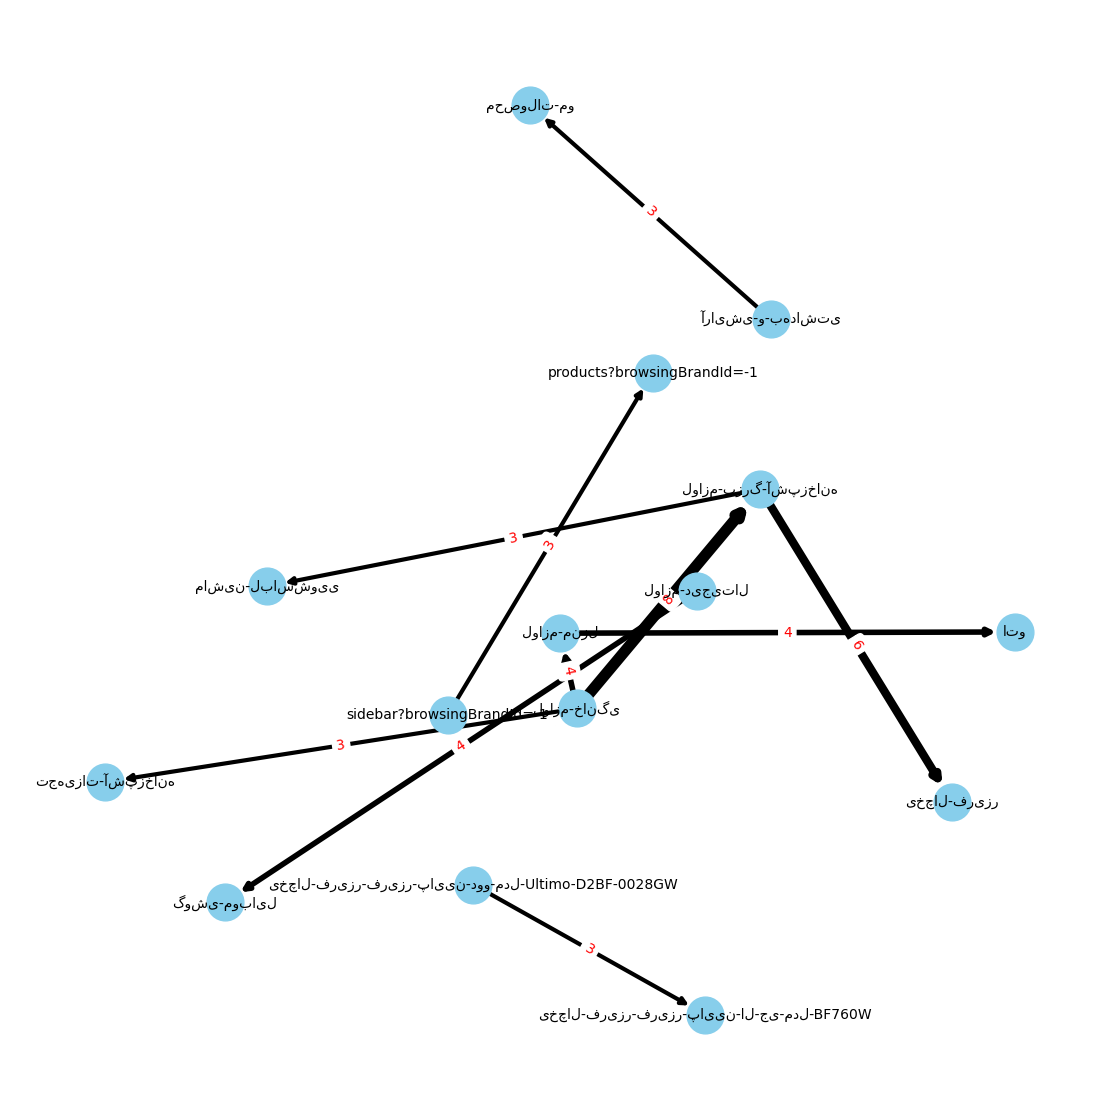

In [6]:
# 学習、予測
import networkx as nx
import matplotlib.pyplot as plt
import time
# 最小カウントを設定
minimumCount = 3
# エッジのリストを作成し、遷移の数をカウント
transition_counts = dataFrame.groupby(['Request', 'next_request']).size().reset_index(name='count')
# グラフを作成し、エッジの属性として遷移の数を格納
G = nx.DiGraph()
for _, row in transition_counts.iterrows():
    if row['Request'] != row['next_request']:
        G.add_edge(row['Request'], row['next_request'], weight=row['count'])
# エッジの重みが最小カウント以上のものだけをフィルタリング
filtered_edges = [(u, v, d['weight']) for u, v, d in G.edges(data=True) if d.get('weight', 0) >= minimumCount]

# フィルタリングされたエッジで新しいグラフを作成
filtered_G = nx.DiGraph()
filtered_G.add_weighted_edges_from(filtered_edges)

# フィルタリングされたグラフを描画
plt.figure(figsize=(11, 11))
pos_filtered = nx.spring_layout(filtered_G, k=0.1, iterations=2)
edge_widths_filtered = [filtered_G[u][v]['weight'] for u, v in filtered_G.edges()]
edge_labels_filtered = {(u, v): filtered_G[u][v]['weight'] for u, v in filtered_G.edges()}
nx.draw(filtered_G, pos_filtered, with_labels=True, node_size=700, node_color='skyblue', font_size=10, width=edge_widths_filtered)
nx.draw_networkx_edge_labels(filtered_G, pos_filtered, edge_labels=edge_labels_filtered, font_color='red')
plt.show()